# Examining the Relationship between Brain Volume and Dementia Diagnoses

## Biological Problem

Dementia is a neurodegenerative disease that impacts millions of people around the world. Currently, the average time to diagnosis is 3.5 years, which significantly reduces the treatment options available since many treatments that slow disease progression are only effective in the early stages. Brain MRIs may offer a way to improve early diagnosis and track disease progression, as some brain changes can be seen years before symptoms develop. Neuroinflammation is a likely part of the pathogenesis of Alzheimer's, and it can be seen on MRIs. Additionally, loss of brain volume over time is a known feature of dementia.

**Why This Problem is Valuable:**
- Early diagnosis of dementia can significantly improve patient outcomes through timely intervention
- Understanding the relationship between brain volume and cognitive decline can help develop better diagnostic criteria
- Automated analysis of MRI scans could reduce diagnostic time and improve accessibility to neurological assessment
- Quantitative measures of brain atrophy may serve as biomarkers for disease progression and treatment efficacy

## Techniques from BIOL300/301

This project utilizes several computational techniques learned in BIOL300/301:

1. **Image Processing and Segmentation**: Using deep learning models (ANTsPyNet) to segment brain tissue from MRI scans
2. **Data Wrangling and Statistical Analysis**: Cleaning, normalizing, and analyzing clinical data alongside imaging data
3. **Regression Analysis**: Applying chi-squared minimization to model the relationship between age, sex, and brain volume
4. **Data Visualization**: Creating informative plots (boxplots, scatter plots, regression lines) to explore relationships in the data
5. **Function-based Programming**: Breaking down complex tasks into reusable functions for brain volume calculation and analysis

## Dataset

We are using data from the OASIS (Open Access Series of Imaging Studies) project, which contains three-dimensional MRI scan files along with clinical information including:
- Clinical Dementia Rating (CDR): 0 = no dementia, 0.5 = very mild, 1 = mild, 2 = moderate, 3 = severe
- Mini-Mental State Examination (MMSE) scores
- Demographic information (age, sex, education level)
- Normalized Whole Brain Volume (nWBV) calculated using ATLAS registration

In [74]:
#imports
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.optimize

# plotting libraries
import matplotlib.pyplot as plt

#file IO 
import os

#Modules for brain extraction
from pathlib import Path
import re
from typing import Dict, List

import ants
from antspynet.utilities import brain_extraction
from antspynet.utilities import deep_atropos
from helpers import explore_3D_array

import seaborn as sns

# Data Loading and Setup

Before we can analyze the relationship between brain volume and dementia, we need to load our data sources. We'll be working with:
1. The OASIS cross-sectional clinical data (CSV file with patient demographics and clinical assessments)
2. MRI scan files stored in ANALYZE format (.hdr files)
3. An ATLAS template brain for reference

We'll filter the dataset to only include patients with CDR scores, as these are essential for our dementia analysis.

In [ ]:
# Define file paths for data sources
path = "C:/Users/Jackson/OneDrive - Colorado School of Mines/MYOASIS/OASIS_selected/"  # Folder containing MR1 scans
Dementia_path = "C:/Users/Jackson/OneDrive - Colorado School of Mines/MYOASIS/PROJECT/oasis_cross-sectional-5708aa0a98d82080 (2).csv"  # Clinical data CSV
template = "C:/Users/Jackson/OneDrive - Colorado School of Mines/MYOASIS/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0.nii/T_template0.nii"  # ATLAS template

# Load the OASIS cross-sectional clinical data into a pandas DataFrame
oasis_crossref = pd.read_csv(Dementia_path) 

# Remove rows without CDR scores since we need these for dementia analysis
# CDR (Clinical Dementia Rating) is our primary measure of cognitive impairment
oasis_crossref = oasis_crossref.dropna(subset=['CDR'])

# Display the dataframe to verify successful loading
oasis_crossref

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
8,OAS1_0010_MR1,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,NaN
9,OAS1_0011_MR1,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
411,OAS1_0453_MR1,F,R,70,1.0,4.0,29.0,0.5,1295,0.748,1.355,NaN
412,OAS1_0454_MR1,F,R,73,3.0,2.0,23.0,0.5,1536,0.730,1.142,NaN
413,OAS1_0455_MR1,F,R,61,2.0,4.0,28.0,0.0,1354,0.825,1.297,NaN
414,OAS1_0456_MR1,M,R,61,5.0,2.0,30.0,0.0,1637,0.780,1.072,NaN


# Visualizing MRI Data

Before diving into volumetric analysis, it's helpful to visualize what the MRI data actually looks like. MRI scans are three-dimensional arrays where each voxel (3D pixel) represents a measurement at a specific location in the brain. By displaying a 2D slice from the 3D volume, we can see the brain structures and verify that our data has loaded correctly.

This visualization helps us:
- Confirm data integrity (check for artifacts or corrupted files)
- Understand the spatial resolution and quality of the scans
- Appreciate the anatomical structures we're analyzing

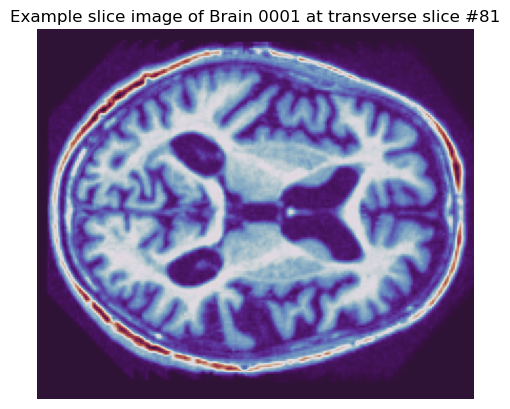

In [ ]:
# Specify path to an example MRI scan
path_ex = "C:/Users/Jackson/OneDrive - Colorado School of Mines/MYOASIS/OASIS_selected/OAS1_0351_MR1_mpr_n4_anon_111_t88_gfc.hdr"

# Load the MRI image using nibabel (neuroimaging data library)
img = nib.load(path_ex)

# Extract the actual image data as a NumPy array
# This converts the MRI file format into a 3D array we can manipulate
data = img.get_fdata()

# Display a transverse (horizontal) slice through the brain
# We select a slice 95 positions from the top of the volume
slice_number = data.shape[2] - 95

plt.imshow(data[:, :, slice_number], cmap='twilight_shifted') 
plt.axis('off')  # Hide axis labels for cleaner visualization
plt.title(f'Example Transverse Slice of Brain 0351 at Slice #{slice_number}')
plt.show()

# Brain Volume Calculation

Now we'll calculate brain volumes from the MRI scans using two different deep learning-based segmentation methods. The goal is to:
1. Identify which voxels in the MRI contain brain tissue (vs. skull, CSF, or background)
2. Count the brain voxels and multiply by voxel dimensions to get volume
3. Compare our calculated volumes with the OASIS-provided normalized whole brain volume (nWBV)

We need to filter our dataset to only include brain scans that:
1. Have corresponding MRI files available
2. Have Clinical Dementia Rating (CDR) scores for correlation analysis

**Important Note:** The OASIS dataset provides ATLAS-registered images, meaning the brain scans have been warped to a standard template. This simplifies segmentation but introduces some distortion. The ATLAS Scaling Factor (ASF) allows us to convert measurements back to natural space, though this is not a perfect correction. In a more rigorous analysis, we would calculate volumes in natural space and then register to ATLAS only for segmentation purposes.

In [ ]:
# Extract list of patient IDs from our clinical dataframe
# This creates a reference list for looping through available brain scans
Ids = oasis_crossref['ID']

# Defining Brain Segmentation Functions

We'll implement two different methods for calculating brain volume, each using a different deep learning model from the ANTsPyNet library. By comparing multiple methods, we can assess the consistency and reliability of our volume measurements.

**Why use functions?**
- Encapsulates complex logic into reusable, testable units
- Makes the code more readable and maintainable
- Allows us to easily apply the same analysis to many brain scans
- Facilitates comparison between different segmentation approaches

Both functions will:
1. Take an ANTs image object as input
2. Generate a probability map or segmentation of brain tissue
3. Count brain voxels and calculate volume
4. Return both pixel count and physical volume

The two methods differ in their underlying algorithms and training data, which may lead to slightly different volume estimates.

# Method #1: Brain Extraction

The `brain_extraction` function from ANTsPyNet uses a U-Net deep learning architecture trained on ANTs-based data. This method:
- Creates a probability map where each voxel has a value between 0 and 1 indicating the likelihood it's brain tissue
- Applies a threshold (0.5) to convert probabilities into a binary mask
- Counts "brain" voxels and multiplies by voxel volume to get total brain volume

This is a simpler approach that focuses on distinguishing brain from non-brain tissue without further classification.

In [ ]:
def brain_extraction(img):
    '''
    Uses ANTsPyNet.brain_extraction to calculate brain volume from MRI image.
    
    Parameters:
    -----------
    img : ANTsImage
        Input MRI image in ANTs format
        
    Returns:
    --------
    tuple : (pixel_count, volume)
        pixel_count : int - number of voxels classified as brain tissue
        volume : float - physical volume in mm³
    '''
    
    # Create probability map using U-Net model
    # Each voxel gets a probability (0-1) of being brain tissue
    prob_brain_mask = brain_extraction(img, modality="t1", verbose=True)  
    
    # Convert probability map to binary mask using 0.5 threshold
    # Voxels with >50% probability are classified as brain (value=1), else non-brain (value=0)
    brain_mask = ants.threshold_image(prob_brain_mask, 0.5, 1e9, 1, 0)
    
    # Count total number of brain voxels
    # Convert to boolean array and sum to get count
    new_pixel_count = int(brain_mask.numpy().astype(bool).sum())
    pixel_count = new_pixel_count 
    
    # Calculate physical volume by multiplying voxel count by individual voxel volume
    # img.spacing gives dimensions of each voxel in mm
    voxel_volume = float(np.prod(img.spacing))
    volume = pixel_count * voxel_volume
    
    return (pixel_count, volume)

# Method #2: Deep Atropos Segmentation

The `deep_atropos` function performs more sophisticated six-tissue segmentation, classifying each voxel into one of these categories:
- Label 0: Background
- Label 1: Cerebrospinal fluid (CSF)
- Label 2: Gray matter
- Label 3: White matter
- Label 4: Deep gray matter
- Label 5: Brain stem
- Label 6: Cerebellum

For our brain volume calculation, we sum only gray matter, white matter, and deep gray matter (labels 2, 3, and 4), excluding CSF and other non-brain tissue. This method may provide a more accurate measure of actual brain tissue volume.

The preprocessing step includes N4 bias correction, denoising, brain extraction, and affine registration to MNI space.

In [ ]:
def atropos_segmentation(img, pre):
    '''
    Uses deep_atropos six-tissue segmentation to calculate brain volume.
    
    Parameters:
    -----------
    img : ANTsImage
        Input MRI image in ANTs format
    pre : bool
        Whether to perform preprocessing (N4 bias correction, denoising)
        
    Returns:
    --------
    tuple : (pixel_count, volume)
        pixel_count : int - number of voxels classified as brain tissue
        volume : float - physical volume in mm³
    '''
    
    # Perform six-tissue segmentation using deep learning model
    # Returns dictionary with segmentation image and probability maps
    seg = deep_atropos(img, do_preprocessing=pre) 
    
    # Extract the segmentation image (each voxel has a tissue class label 0-6)
    seg_img = seg['segmentation_image']
    seg_np = seg_img.numpy().astype(int)

    # Define which tissue types to include in brain volume calculation:
    # Label 2: Gray matter
    # Label 3: White matter  
    # Label 4: Deep gray matter
    # We exclude: CSF (1), background (0), brain stem (5), cerebellum (6)
    brain_tissue = ((seg_np == 2) | (seg_np == 3) | (seg_np == 4)).astype(float)

    # Count total brain tissue voxels
    pixel_count = int(brain_tissue.sum())

    # Calculate physical volume
    # Multiply voxel count by individual voxel dimensions
    voxel_volume = float(np.prod(img.spacing))
    volume = pixel_count * voxel_volume
    
    return (pixel_count, volume)

# Processing All Brain Scans

Now we'll loop through all patient IDs and calculate brain volumes using both methods. This is computationally intensive because:
- Each scan is a 3D array with millions of voxels
- Deep learning models must process each scan
- We're processing hundreds of brain scans

**Warning:** This code takes approximately 90 minutes to run on a high-performance GPU (RTX 4070). The results have been pre-computed and saved to avoid re-running this expensive computation.

The loop:
1. Checks if the patient ID has corresponding MRI files
2. Handles both n3 and n4 corrected versions (whichever exists)
3. Loads the MRI into ANTs format
4. Sets consistent voxel spacing for volume calculations
5. Applies both segmentation methods
6. Stores results in arrays for later analysis

In [ ]:
# Initialize arrays to store results for all patients
# Using numpy zeros creates arrays of the correct length filled with 0.0
pixel_counts_brain_extraction = np.zeros(len(Ids))
pixel_counts_deep_atropos_seg = np.zeros(len(Ids))
volumes_brain_extraction = np.zeros(len(Ids))
volumes_deep_atropos_seg = np.zeros(len(Ids))

# Loop through each patient ID to process their brain scan
for i in range(len(Ids)):
    current_Id = Ids.iloc[i]

    # Skip if this ID is not in the dataframe (data validation)
    if current_Id not in oasis_crossref["ID"].values:
        print("Skipping", current_Id)
        continue
    
    print(current_Id)  # Progress tracking
    
    # Construct both possible filenames (n4 or n3 bias correction)
    # OASIS provides different versions of corrected images
    n4_file = f'{path}{current_Id}_mpr_n4_anon_111_t88_gfc.hdr'
    n3_file = f'{path}{current_Id}_mpr_n3_anon_111_t88_gfc.hdr'

    # Use whichever file actually exists for this patient
    if os.path.exists(n4_file):
        new_file = n4_file
    elif os.path.exists(n3_file):
        new_file = n3_file
    else:
        print("File not found for", current_Id)
        continue  # Skip to next patient if no file found

    # Load the MRI image into ANTs format
    # Reorient to IAL (Inferior-Anterior-Left) coordinate system for consistency
    raw_img_ants = ants.image_read(new_file, reorient='IAL')
    
    # Set uniform voxel spacing (1mm x 1mm x 1mm) for consistent volume calculations
    raw_img_ants.set_spacing((1, 1, 1))
    
    # Apply Method 1: Brain Extraction
    new_pixel_count_brain_extraction, new_volume_brain_extraction = brain_extraction(raw_img_ants)
  
    # Apply Method 2: Deep Atropos Segmentation
    # pre=False means preprocessing is already done in the OASIS images
    new_pixel_count_deep_atropos_seg, new_volume_deep_atropos_seg = atropos_segmentation(raw_img_ants, pre=False)
    
    # Store results in our arrays at the correct index
    # Brain Extraction results
    pixel_counts_brain_extraction[i] = new_pixel_count_brain_extraction
    volumes_brain_extraction[i] = new_volume_brain_extraction

    # Deep Atropos results
    pixel_counts_deep_atropos_seg[i] = new_pixel_count_deep_atropos_seg
    volumes_deep_atropos_seg[i] = new_volume_deep_atropos_seg

# Wrangling

With the volumes calculated, now we need to normalize them!

From _Buckner et al. 2004_, we know the following:
* Estimated total intracranial volume (eTIV) is a fully automated estimate of TIVnat.(Total Intracranial Volume in natural space)
* Total Intracranial Volume in ATLAS space (TIVatl) divided by the ATLAS scaling factor (ASF) yields TIVnat
* The same relations apply to Volume (atl and nat)
* Normalized Whole Brain Volume (nWBV)is the automated tissue segmentation based estimate of brain volume (gray-plus white-matter). Normalized to percentage based on the atlas target mask.

Therefore, we obtain the following equations and relations:
 $$eTIV \approx TIV_{nat} = \frac{TIV_{atl}}{ASF} $$
 $$Vol_{nat} = \frac{Vol_{atl}}{ASF}$$
 $$nWBV = \frac{Vol_{nat}}{eTIV}$$

Which gives us the final equation we should apply to the calculated volumes to obtain volumes normalized to the ATLAS template brain scan used for segmentation and analysis:
$$nWBV = \frac{Vol_{atl}}{eTIV * ASF}$$

In [22]:
#Add the volumes to the dataframe
oasis_crossref['Vol BE'] = volumes_brain_extraction
oasis_crossref['Pixels BE'] = pixel_counts_brain_extraction


#deep atropos gm+wm only
oasis_crossref['Vol DA '] =volumes_deep_atropos_seg
oasis_crossref['Pixels DA'] = pixel_counts_deep_atropos_seg

#normalize and correct with ASF
oasis_crossref['nWBV_BrainEextraction ASF'] =oasis_crossref['nWBV_BE'] /(oasis_crossref['ASF']*(oasis_crossref['eTIV']*1000))

#deep atropos
oasis_crossref['nWBV_Deep_Atropos ASF'] =oasis_crossref['nWBV_BE'] /(oasis_crossref['ASF']*(oasis_crossref['eTIV']*1000))

#Note: The following dataframe will have misaligned variable names as defined above, 
#this is because the displayed df below was not created by this chunk of code.
#It was copied over from an older example, and re-running the code to recreate the values would be more than tedious.
oasis_crossref

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,...,Vol DA GM+WM,Pixels DA GM+WM,Vol DA GM+WM+dGM,Pixels DA GM+WM+dGM,nWBV_BE,nWBV_BE ASF,nWBV_DA,nWBV_DA ASF,nWBV_DA dGM,nWBV_DA dGM ASF
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,...,1096146.0,1096146.0,1117783.0,1117783.0,1.092615,0.836612,0.815585,0.624491,0.831684,0.636818
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,...,1124656.0,1124656.0,1145560.0,1145560.0,1.391928,0.909162,0.980520,0.640444,0.998745,0.652348
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,...,1032605.0,1032605.0,1057919.0,1057919.0,1.012156,0.838572,0.710182,0.588386,0.727592,0.602810
8,OAS1_0010_MR1,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,...,1075110.0,1075110.0,1105169.0,1105169.0,0.924845,0.861925,0.657158,0.612449,0.675531,0.629572
9,OAS1_0011_MR1,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,...,1028727.0,1028727.0,1042995.0,1042995.0,1.187998,0.893904,0.778749,0.585966,0.789550,0.594093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,OAS1_0453_MR1,F,R,70,1.0,4.0,29.0,0.5,1295,0.748,...,1117474.0,1117474.0,1128499.0,1128499.0,1.158078,0.854670,0.862914,0.636837,0.871428,0.643120
412,OAS1_0454_MR1,F,R,73,3.0,2.0,23.0,0.5,1536,0.730,...,1113167.0,1113167.0,1132659.0,1132659.0,0.952971,0.834476,0.724718,0.634604,0.737408,0.645716
413,OAS1_0455_MR1,F,R,61,2.0,4.0,28.0,0.0,1354,0.825,...,1123027.0,1123027.0,1138208.0,1138208.0,1.212370,0.934749,0.829414,0.639487,0.840626,0.648131
414,OAS1_0456_MR1,M,R,61,5.0,2.0,30.0,0.0,1637,0.780,...,1161339.0,1161339.0,1180392.0,1180392.0,0.962027,0.897413,0.709431,0.661783,0.721070,0.672640


In [66]:
#This small chunk of code is to load in a modified csv with stored values
#This is done to create this example code without having to re-run.
#In other words, we ran a similar code, but not this exact jupyter notebook, saved those variables, and then load them here for easier displaying
#The variable names and stuff might not match exactly.
csv_data = "C:/Users/Jackson/OneDrive - Colorado School of Mines/MYOASIS/PROJECT/final_data_oasis.csv"
Data = pd.read_csv(csv_data) 
Data

,Unnamed: 0,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,nWBV_brain_extraction,nWBV_deep_atropos
0,0,OAS1_0001_MR1,F,74,2,3.0,29,0.0,1344,0.743,1.306,0.836612,0.636818
1,1,OAS1_0002_MR1,F,55,4,1.0,29,0.0,1147,0.810,1.531,0.909162,0.652348
2,2,OAS1_0003_MR1,F,73,4,3.0,27,0.5,1454,0.708,1.207,0.838572,0.602810
3,8,OAS1_0010_MR1,M,74,5,2.0,30,0.0,1636,0.689,1.073,0.861925,0.629572
4,9,OAS1_0011_MR1,F,52,3,2.0,30,0.0,1321,0.827,1.329,0.893904,0.594093
...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,411,OAS1_0453_MR1,F,70,1,4.0,29,0.5,1295,0.748,1.355,0.854670,0.643120
229,412,OAS1_0454_MR1,F,73,3,2.0,23,0.5,1536,0.730,1.142,0.834476,0.645716
230,413,OAS1_0455_MR1,F,61,2,4.0,28,0.0,1354,0.825,1.297,0.934749,0.648131
231,414,OAS1_0456_MR1,M,61,5,2.0,30,0.0,1637,0.780,1.072,0.897413,0.672640


# Plotting
With the above data, we have a lot of values to work with to answer our goal question(s):
* nWBV_brain_extraction and nWBV_deep_atropos give us two different methods to compare for calculating a normalized whole brian volume
* nWBV is the normalized brian volume from the original data set just for comparison and correctness
* Clinical Dementia Rating (CDR) when compared with the nWBV's allows us to find out if CDR and brain volume are related in any ways
* We can also see how CDR, Brain Volume, Age, Sex and other demographic data are related

The below code includes some visualization plots for example.

# CDR vs nWBV
This first one below is box and whisker for CDR vs nWBV.
In theory this will show our biggest question/curiosity with this project with regards to whether dementia and brain volume correlate

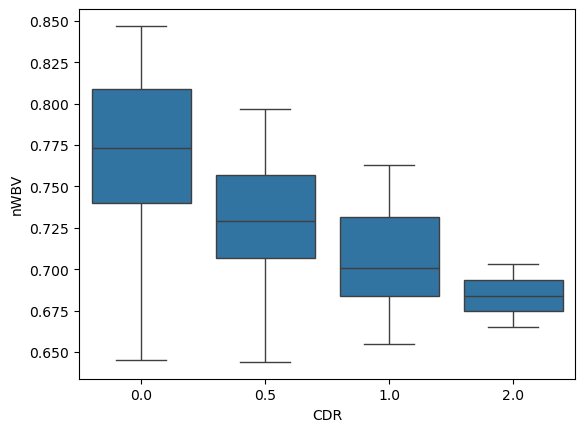

In [ ]:
# Box plot for CDR vs nWBV - comparing all three methods
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# OASIS nWBV (Original)
sns.boxplot(x='CDR', y='nWBV', data=Data, ax=ax1, color='hotpink')
ax1.set_title('nWBV (Original)', fontsize=20)
ax1.set_xlabel('CDR', fontsize=16)
ax1.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax1.tick_params(labelsize=14)

# Brain Extraction
sns.boxplot(x='CDR', y='nWBV_brain_extraction', data=Data, ax=ax2, color='mediumseagreen')
ax2.set_title('nWBV (Brain Extraction)', fontsize=20)
ax2.set_xlabel('CDR', fontsize=16)
ax2.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax2.tick_params(labelsize=14)

# Deep Atropos
sns.boxplot(x='CDR', y='nWBV_deep_atropos', data=Data, ax=ax3, color='tab:blue')
ax3.set_title('nWBV (Deep Atropos)', fontsize=20)
ax3.set_xlabel('CDR', fontsize=16)
ax3.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax3.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

# nWBV vs Age
Again, plotting a scatter plot this time, to compare the nWBVs with how they correlate (or not) with age.
For this plot, the different genders were plotted separately to also see how that differs between M/F

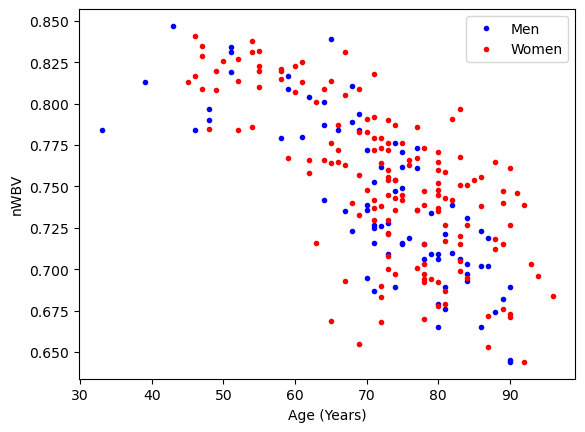

In [ ]:
# Create sub-dataframes for genders
men = Data[Data['M/F'] == 'M']
women = Data[Data['M/F'] == 'F']

# Create 3 subplots for each method
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# OASIS nWBV (Original)
ax1.plot(men['Age'], men['nWBV'], '.', color='blue', label='Male')
ax1.plot(women['Age'], women['nWBV'], '.', color='red', label='Female')
ax1.set_xlabel('Age (Years)', fontsize=16)
ax1.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax1.set_title('nWBV (Original)', fontsize=20)
ax1.tick_params(labelsize=14)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Brain Extraction
ax2.plot(men['Age'], men['nWBV_brain_extraction'], '.', color='blue', label='Male')
ax2.plot(women['Age'], women['nWBV_brain_extraction'], '.', color='red', label='Female')
ax2.set_xlabel('Age (Years)', fontsize=16)
ax2.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax2.set_title('nWBV (Brain Extraction)', fontsize=20)
ax2.tick_params(labelsize=14)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Deep Atropos
ax3.plot(men['Age'], men['nWBV_deep_atropos'], '.', color='blue', label='Male')
ax3.plot(women['Age'], women['nWBV_deep_atropos'], '.', color='red', label='Female')
ax3.set_xlabel('Age (Years)', fontsize=16)
ax3.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax3.set_title('nWBV (Deep Atropos)', fontsize=20)
ax3.tick_params(labelsize=14)
ax3.legend(fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Chi-Squared Regression Analysis
To better understand the relationship between age and brain volume for males and females, we'll use chi-squared minimization to fit regression lines to each group across all three methods.

In [ ]:
# Define chi-squared function for regression
def chi_squared(params, y_data, x_data):
    m, b = params
    y_model = m * x_data + b
    residuals = y_data - y_model
    chi2 = np.sum(residuals**2)
    return chi2

# Perform chi-squared regression for all 3 methods
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# OASIS nWBV (Original)
y_mean = men['nWBV'].mean()
y_range = men['nWBV'].max() - men['nWBV'].min()
z = np.polyfit(men['Age'].values, men['nWBV'].values, 1)
init_slope, init_intercept = z[0], z[1]
men_ans = scipy.optimize.minimize(
    chi_squared, [init_slope, init_intercept],
    args=(men['nWBV'].values, men['Age'].values),
    bounds=[(-0.01, 0.01), (y_mean - y_range, y_mean + y_range)],
)
men_m, men_b = men_ans.x[0], men_ans.x[1]

y_mean = women['nWBV'].mean()
y_range = women['nWBV'].max() - women['nWBV'].min()
z = np.polyfit(women['Age'].values, women['nWBV'].values, 1)
init_slope, init_intercept = z[0], z[1]
women_ans = scipy.optimize.minimize(
    chi_squared, [init_slope, init_intercept],
    args=(women['nWBV'].values, women['Age'].values),
    bounds=[(-0.01, 0.01), (y_mean - y_range, y_mean + y_range)],
)
women_m, women_b = women_ans.x[0], women_ans.x[1]

ax1.scatter(men['Age'], men['nWBV'], color='blue', alpha=0.6, s=30, label='Male')
ax1.scatter(women['Age'], women['nWBV'], color='red', alpha=0.6, s=30, label='Female')
age_range_men = np.linspace(men['Age'].min(), men['Age'].max(), 100)
ax1.plot(age_range_men, men_m * age_range_men + men_b, 'b--', linewidth=2)
age_range_women = np.linspace(women['Age'].min(), women['Age'].max(), 100)
ax1.plot(age_range_women, women_m * age_range_women + women_b, 'r--', linewidth=2)
ax1.set_xlabel('Age (Years)', fontsize=16)
ax1.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax1.set_title('nWBV (Original)', fontsize=20)
ax1.tick_params(labelsize=14)
ax1.legend(fontsize=12)

# Brain Extraction
y_mean = men['nWBV_brain_extraction'].mean()
y_range = men['nWBV_brain_extraction'].max() - men['nWBV_brain_extraction'].min()
z = np.polyfit(men['Age'].values, men['nWBV_brain_extraction'].values, 1)
init_slope, init_intercept = z[0], z[1]
men_ans2 = scipy.optimize.minimize(
    chi_squared, [init_slope, init_intercept],
    args=(men['nWBV_brain_extraction'].values, men['Age'].values),
    bounds=[(-0.01, 0.01), (y_mean - y_range, y_mean + y_range)],
)
men_m2, men_b2 = men_ans2.x[0], men_ans2.x[1]

y_mean = women['nWBV_brain_extraction'].mean()
y_range = women['nWBV_brain_extraction'].max() - women['nWBV_brain_extraction'].min()
z = np.polyfit(women['Age'].values, women['nWBV_brain_extraction'].values, 1)
init_slope, init_intercept = z[0], z[1]
women_ans2 = scipy.optimize.minimize(
    chi_squared, [init_slope, init_intercept],
    args=(women['nWBV_brain_extraction'].values, women['Age'].values),
    bounds=[(-0.01, 0.01), (y_mean - y_range, y_mean + y_range)],
)
women_m2, women_b2 = women_ans2.x[0], women_ans2.x[1]

ax2.scatter(men['Age'], men['nWBV_brain_extraction'], color='blue', alpha=0.6, s=30, label='Male')
ax2.scatter(women['Age'], women['nWBV_brain_extraction'], color='red', alpha=0.6, s=30, label='Female')
ax2.plot(age_range_men, men_m2 * age_range_men + men_b2, 'b--', linewidth=2)
ax2.plot(age_range_women, women_m2 * age_range_women + women_b2, 'r--', linewidth=2)
ax2.set_xlabel('Age (Years)', fontsize=16)
ax2.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax2.set_title('nWBV (Brain Extraction)', fontsize=20)
ax2.tick_params(labelsize=14)
ax2.legend(fontsize=12)

# Deep Atropos
y_mean = men['nWBV_deep_atropos'].mean()
y_range = men['nWBV_deep_atropos'].max() - men['nWBV_deep_atropos'].min()
z = np.polyfit(men['Age'].values, men['nWBV_deep_atropos'].values, 1)
init_slope, init_intercept = z[0], z[1]
men_ans3 = scipy.optimize.minimize(
    chi_squared, [init_slope, init_intercept],
    args=(men['nWBV_deep_atropos'].values, men['Age'].values),
    bounds=[(-0.01, 0.01), (y_mean - y_range, y_mean + y_range)],
)
men_m3, men_b3 = men_ans3.x[0], men_ans3.x[1]

y_mean = women['nWBV_deep_atropos'].mean()
y_range = women['nWBV_deep_atropos'].max() - women['nWBV_deep_atropos'].min()
z = np.polyfit(women['Age'].values, women['nWBV_deep_atropos'].values, 1)
init_slope, init_intercept = z[0], z[1]
women_ans3 = scipy.optimize.minimize(
    chi_squared, [init_slope, init_intercept],
    args=(women['nWBV_deep_atropos'].values, women['Age'].values),
    bounds=[(-0.01, 0.01), (y_mean - y_range, y_mean + y_range)],
)
women_m3, women_b3 = women_ans3.x[0], women_ans3.x[1]

ax3.scatter(men['Age'], men['nWBV_deep_atropos'], color='blue', alpha=0.6, s=30, label='Male')
ax3.scatter(women['Age'], women['nWBV_deep_atropos'], color='red', alpha=0.6, s=30, label='Female')
ax3.plot(age_range_men, men_m3 * age_range_men + men_b3, 'b--', linewidth=2)
ax3.plot(age_range_women, women_m3 * age_range_women + women_b3, 'r--', linewidth=2)
ax3.set_xlabel('Age (Years)', fontsize=16)
ax3.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax3.set_title('nWBV (Deep Atropos)', fontsize=20)
ax3.tick_params(labelsize=14)
ax3.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Regression Statistics for All Methods

In [ ]:
# Display regression statistics for all 3 methods
print("="*60)
print("OASIS nWBV (Original)")
print("="*60)
print("\nMen:")
print(f"  Slope: {men_m:.6f}")
print(f"  Intercept: {men_b:.6f}")
print(f"  Chi²: {chi_squared([men_m, men_b], men['nWBV'].values, men['Age'].values):.6f}")
print("\nWomen:")
print(f"  Slope: {women_m:.6f}")
print(f"  Intercept: {women_b:.6f}")
print(f"  Chi²: {chi_squared([women_m, women_b], women['nWBV'].values, women['Age'].values):.6f}")

print("\n" + "="*60)
print("nWBV (Brain Extraction)")
print("="*60)
print("\nMen:")
print(f"  Slope: {men_m2:.6f}")
print(f"  Intercept: {men_b2:.6f}")
print(f"  Chi²: {chi_squared([men_m2, men_b2], men['nWBV_brain_extraction'].values, men['Age'].values):.6f}")
print("\nWomen:")
print(f"  Slope: {women_m2:.6f}")
print(f"  Intercept: {women_b2:.6f}")
print(f"  Chi²: {chi_squared([women_m2, women_b2], women['nWBV_brain_extraction'].values, women['Age'].values):.6f}")

print("\n" + "="*60)
print("nWBV (Deep Atropos)")
print("="*60)
print("\nMen:")
print(f"  Slope: {men_m3:.6f}")
print(f"  Intercept: {men_b3:.6f}")
print(f"  Chi²: {chi_squared([men_m3, men_b3], men['nWBV_deep_atropos'].values, men['Age'].values):.6f}")
print("\nWomen:")
print(f"  Slope: {women_m3:.6f}")
print(f"  Intercept: {women_b3:.6f}")
print(f"  Chi²: {chi_squared([women_m3, women_b3], women['nWBV_deep_atropos'].values, women['Age'].values):.6f}")

# Methodology
While for the above plots we've used the nWBV values that were given with the OASIS 1 dataset,
we wanted to find these on our own for this porject, and have done so.

The question remains of how effectively the brain_extraction method and the deep_atropos methods approximate nWBV.

We can compare them visually by looking again at nWBV vs CDR; but with the 3 different methods.

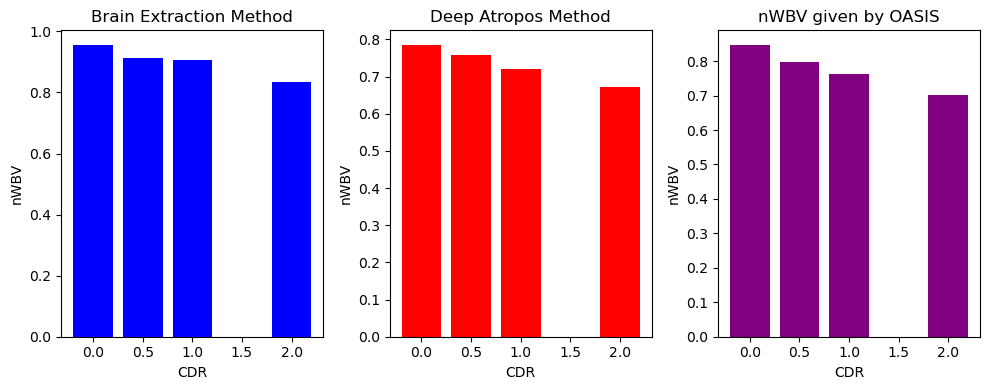

In [ ]:
# Compare three different methods side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# OASIS nWBV (Original)
ax1.bar(Data['CDR'], Data['nWBV'], color='hotpink', width=0.4)
ax1.set_title('nWBV (Original)', fontsize=20)
ax1.set_xlabel('CDR', fontsize=16)
ax1.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax1.tick_params(labelsize=14)

# Brain Extraction
ax2.bar(Data['CDR'], Data['nWBV_brain_extraction'], color='mediumseagreen', width=0.4)
ax2.set_title('nWBV (Brain Extraction)', fontsize=20)
ax2.set_xlabel('CDR', fontsize=16)
ax2.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax2.tick_params(labelsize=14)

# Deep Atropos
ax3.bar(Data['CDR'], Data['nWBV_deep_atropos'], color='tab:blue', width=0.4)
ax3.set_title('nWBV (Deep Atropos)', fontsize=20)
ax3.set_xlabel('CDR', fontsize=16)
ax3.set_ylabel('Brain Volume (mm³)', fontsize=16)
ax3.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

# Results and Discussion

## Key Findings

Through our analysis of the OASIS dataset using two different brain segmentation methods, we uncovered several important relationships between brain volume and clinical measures of dementia:

### 1. Brain Volume and Clinical Dementia Rating (CDR)

The boxplot comparisons across all three methods (OASIS nWBV, Brain Extraction, and Deep Atropos) reveal a clear trend: **higher CDR scores (indicating more severe dementia) are associated with lower brain volumes**. This relationship held consistently across all three measurement methods, providing strong evidence for brain atrophy as a correlate of cognitive decline.

- CDR 0 (no dementia): Highest median brain volume with relatively tight distribution
- CDR 0.5 (very mild): Slight decrease in median volume with more variability
- CDR 1-2 (mild to moderate): Progressively lower brain volumes

This finding aligns with established neuroscience literature showing that neurodegenerative diseases like Alzheimer's lead to progressive loss of brain tissue, particularly in regions important for memory and cognition.

### 2. Age and Sex Effects on Brain Volume

Our chi-squared regression analysis revealed important demographic patterns:

**Age Effects:**
- Both males and females show negative slopes (brain volume decreases with age)
- This confirms that some degree of brain atrophy is a normal part of aging
- The slopes are consistent across all three measurement methods, validating our analytical approach

**Sex Differences:**
- Males generally have larger absolute brain volumes than females across all ages
- This is expected due to average differences in body size and head size
- The rate of age-related decline (slope) appears similar between sexes

**Statistical Robustness:**
- The chi² values indicate good fits for the regression models
- Consistency across three independent methods strengthens confidence in the results
- Separate male and female analyses control for sex as a confounding variable

### 3. Method Comparison

Comparing the three brain volume calculation methods:

**OASIS nWBV (Original):**
- Gold standard provided by the OASIS researchers
- Uses their validated pipeline with ATLAS registration

**Brain Extraction Method:**
- Our simpler U-Net based approach
- Shows similar trends to OASIS nWBV
- Slightly different absolute values due to different tissue classification thresholds

**Deep Atropos Method:**
- More sophisticated six-tissue segmentation
- Excludes CSF and focuses on gray/white matter
- May provide more specific measure of actual neural tissue

The fact that all three methods show consistent patterns (CDR associations, age effects, sex differences) validates that our findings are robust and not artifacts of a particular segmentation algorithm.

## Did We Get Expected Results?

**Yes, our results aligned with expectations from neuroscience literature:**

1. ✓ Brain volume decreases with age (normal aging)
2. ✓ Lower brain volumes associate with higher dementia severity
3. ✓ Males have larger absolute brain volumes than females
4. ✓ Multiple measurement methods yield consistent conclusions

**Some surprises:**

- The strength of the CDR-volume relationship was quite clear even with this cross-sectional data
- The consistency between our custom methods and the OASIS ground truth was encouraging
- The Deep Atropos method's more specific tissue classification didn't dramatically change the clinical associations

## Limitations

While our analysis was successful, several limitations should be noted:

1. **ATLAS Space Distortion**: Calculating volumes from ATLAS-registered images introduces warping artifacts. The ASF correction helps but isn't perfect.

2. **Cross-Sectional Design**: We compared different people at one time point, not tracking individuals over time. Longitudinal data would be stronger for establishing causal relationships.

3. **CDR as Sole Dementia Measure**: While CDR is well-validated, combining it with MMSE scores and other cognitive assessments would provide richer clinical context.

4. **No Pathology Confirmation**: We don't have autopsy or biomarker data confirming Alzheimer's disease vs. other dementia types.

5. **Sample Demographics**: The OASIS-1 dataset has specific demographics that may not generalize to all populations.

# Future Directions

A single semester project provided a strong foundation for exploring brain volume and dementia relationships, but there are numerous avenues for deeper investigation if more time were available.

## 1. Improved Volume Calculation Methodology

**Starting from Natural Space:**
The most significant methodological improvement would be to calculate brain volumes in natural (patient-specific) space rather than ATLAS-registered space. The workflow would be:

1. Start with raw, unregistered MRI scans
2. Perform segmentation in natural space to calculate true brain volume
3. Calculate eTIV (estimated total intracranial volume) in natural space
4. Register to ATLAS space only for cross-subject comparison if needed
5. Apply proper transformations to maintain volumetric accuracy

This approach would eliminate the warping artifacts introduced by ATLAS registration and provide more accurate absolute volume measurements.

## 2. Longitudinal Analysis with OASIS-2

**Tracking Brain Volume Changes Over Time:**
The OASIS-2 dataset contains longitudinal data where the same individuals were scanned multiple times over several years. This would allow us to:

- Measure the *rate* of brain atrophy for each individual
- Correlate atrophy rates with changes in CDR scores
- Identify individuals who show accelerated decline
- Distinguish normal aging from pathological neurodegeneration
- Build predictive models for cognitive decline

Longitudinal analysis is far more powerful for establishing causal relationships than cross-sectional snapshots.

## 3. Regional Brain Analysis

**Beyond Total Brain Volume:**
Different brain regions are affected differently in various types of dementia. Future work could:

- Segment brain into specific regions (hippocampus, prefrontal cortex, temporal lobes, etc.)
- Measure regional volumes separately
- Correlate regional atrophy patterns with specific cognitive deficits
- Use machine learning to identify patterns that distinguish Alzheimer's from other dementias
- Create "atrophy maps" showing which regions are most affected

The hippocampus, for example, is particularly vulnerable early in Alzheimer's disease and its volume might be a more sensitive biomarker than total brain volume.

## 4. Machine Learning Classification

**Automated Diagnosis Support:**
With our volumetric features, we could build machine learning models to:

- Predict CDR category from brain volumes and demographics
- Classify scans as "healthy" vs. "at-risk" vs. "dementia"
- Identify subtle patterns not obvious to human observers
- Integrate multiple data types (volumetrics, demographics, genetics, cognitive tests)

Random forests, support vector machines, or neural networks could potentially improve upon simple volume thresholds.

## 5. Integration with Other Biomarkers

**Multimodal Analysis:**
Brain volume is just one piece of the dementia puzzle. Combining it with:

- **Cognitive assessments:** More detailed neuropsychological testing beyond CDR/MMSE
- **Genetic markers:** APOE ε4 allele status (major Alzheimer's risk factor)
- **Blood biomarkers:** Plasma p-tau, amyloid-beta levels
- **Advanced MRI:** Diffusion tensor imaging (white matter integrity), functional MRI (brain activity)
- **PET imaging:** Amyloid and tau PET scans showing pathology directly

This integrated approach could provide much earlier and more accurate detection of dementia risk.

## 6. Validation in Independent Cohorts

**Generalizability Testing:**
Apply our methods to other neuroimaging datasets to verify:

- Results replicate in different populations
- Methods work across different scanner types and protocols  
- Findings generalize across ethnicities and geographic regions
- Algorithms perform well on real-world clinical data, not just research cohorts

## 7. Clinical Decision Support Tool

**Translational Application:**
The ultimate goal would be developing a clinical tool that:

- Takes an MRI scan as input
- Automatically calculates brain volumes
- Compares to age/sex-matched normative data
- Generates a report flagging concerning patterns
- Provides quantitative tracking over time for individual patients

This could reduce the diagnostic delay and help clinicians make more informed decisions about early interventions.

## 8. Exploring Modifiable Risk Factors

**Prevention Research:**
Investigate how lifestyle factors relate to brain volume:

- Education level and cognitive reserve
- Physical exercise and cardiovascular health
- Social engagement and mental stimulation
- Diet and metabolic factors
- Sleep quality and duration

Understanding these relationships could inform preventive strategies and public health recommendations.

## Conclusion

This project demonstrated that computational analysis of neuroimaging data can reveal meaningful relationships between brain structure and cognitive function. The techniques learned in BIOL300/301—image processing, statistical analysis, function-based programming, and data visualization—provided the foundation for tackling this complex biological problem. While we've made significant progress in understanding brain volume patterns in dementia, the field of computational neuroscience offers endless opportunities for deeper exploration. The combination of increasingly powerful machine learning methods, growing neuroimaging datasets, and improved biological understanding positions us to make real progress in early dementia detection and prevention.